## SF Data - Business Locations - Analysis
<img src="san-francisco.jpg">

In [2]:
import pandas as pd
import folium
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from folium.plugins import MarkerCluster
import ast

In [3]:
# Reading the dataset. Encoding is included since the dataset is in the Windows character system
df1=pd.read_csv('sf_business_dataset.csv',encoding='cp1252') 

In [4]:
df1.columns

Index(['Location Id', 'Business Account Number', 'Ownership Name', 'DBA Name',
       'Street Address', 'City', 'State', 'Source Zipcode',
       'Business Start Date', 'Business End Date', 'Location Start Date',
       'Location End Date', 'Mail Address', 'Mail City', 'Mail Zipcode',
       'Mail State', 'NAICS Code', 'NAICS Code Description', 'Parking Tax',
       'Transient Occupancy Tax', 'LIC Code', 'LIC Code Description',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries',
       'Business Corridor', 'Business Location'],
      dtype='object')

### Extracting Latitude and Longitude Data
* To perform the first analysis, we need to extract the latitude and longitude from the last column. 
* Initial look at the last column shows that each row in this column contains two '\r' so we can split on this character and create three columns (Address, City & Zip, Latitude/Longitude). 
* When I looked further, I noticed some columns contain only two '\r' so the right way is to perform a reverse split on the last '\r character

In [5]:
df1[['Address','Lat/Long']] = df1['Business Location'].str.rsplit('\r',1,expand=True)

In [6]:
df2=df1

In [7]:
df2=df2.fillna('')

In [8]:
def literal_return(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError) as e:
        return ''

In [9]:
df2['Lat/Long'] = df2['Lat/Long'].apply(literal_return)

### Our objective here is to visualize business in the San Francisco area in a map. Hence we are excluding businesses that do not have this data

In [10]:
df2 = df2[df2['Lat/Long']!='']

* In the next step, the data with State California is filtered. The reason why this is done is because our dataset contains businesses from different states which we do not need for this specific analysis

In [11]:
df_california=df2[df2['State']=='CA']

### We are interested in visualizing active businesses in the San Francisco area. Hence we need to filter all location data of businesses they are open (Not having a location end date)

In [12]:
df_california_active_business=df_california[df_california['Business End Date']=='']

In [13]:
#creating a list of latitudes and longitudes of all businesses
list_lat_long=df_california['Lat/Long'].tolist()

In [14]:
#creating a list of latitudes and longitudes of all active businesses
active_business_lat_long=df_california_active_business['Lat/Long'].tolist()

In [15]:

map4 = folium.Map(location =[37.773977671,-122.354261153],zoom_start =12)
map5 = map4.add_child(MarkerCluster(locations=list_lat_long))


In [16]:
map5.save("Maps/Business_Locations.html")

### Visualization of all businesses in the San Francisco Area (Active and inactive)

<img src="screenshots/San Francisco-Business.png">

In [17]:

map6 = folium.Map(location =[37.773977671,-122.354261153],zoom_start =12)
map7 = map6.add_child(MarkerCluster(locations=active_business_lat_long))


In [18]:
map7.save("Maps/Active_Business_Locations.html")

### Visualization of all active businesses in the San Francisco Area

<img src="screenshots/San Francisco-ActiveBusiness.png">

### CLICK HERE TO VIEW THE MAPS
<a href="Maps/Business_Locations.html">**ALL BUSINESSES - SAN FRANCISCO **</a>

<a href="Maps/Active_Business_Locations.html">**ALL  ACTIVE BUSINESSES - SAN FRANCISCO **</a>

## Inference
* The cluster with the number indicates the number of businesses in that area.
* It can be inferred from the maps that most of the active businesses (more than 50000) are concentrated in North, Northeast location of San Francisco. The number of businesses in South & West part of San Francisco is very less.

Note: 
* I am taking screenshots from the html files created of the maps. There is an issue in my jupyter notebook that prevents me from displaying folium maps inline. I will be resolving it soon
* You can view the maps in real time by clicking the hyperlink here or opening Active_Business_Locations.html file

### Exploring the data to identify categories of business that have few very scarce presence in San Francisco

In [19]:
df_bus_type=df1

In [20]:
df_bus_type=df_bus_type.fillna('')

In [21]:
df_bus_type['Source Zipcode']=df_bus_type['Source Zipcode'].astype(str)

* Since the dataset contains data from different cities in the San Francisco Bay Area and some data from other states, I am filtering the state to include only data from **California** and I am filtering zipcodes starting with 94. 

***Reasons for filtering zipcodes starting with 94: ***
 * The dataset contains the city name as a column, hence my initial approach was to filter the city "San Francisco". Unfortunately, the spelling of San Francisco is different in each record and there are many variants. This does not seem to be the best way to filter the data since doing so will filter out valuable information.
 * Exploring https://data.sfgov.org/ and a quick look in www.google.com reveals the fact that all zipcodes in San Francisco starts with 94. Though filtering this way might include some cities in the Bay Area in the South (Like Mountain View, Palo Alto & Sunnyvale), this option was better since there are very few records of businesses in this area compared to data from other states & the Easy Bay (Oakland). This way we can get a better idea of types of businesses in and around San Francisco

In [22]:
df_bus_type_sf=df_bus_type[(df_bus_type['Source Zipcode'].str.startswith('94'))&(df_bus_type['State']=='CA')]

In [23]:
#Filtering businesses with NAICS Descriptions
df_bus_type_sf_type=df_bus_type_sf[df_bus_type_sf['NAICS Code Description']!='']

### Some exploratory analysis to see if a business account number appears in more than one NAICS Description

In [24]:
df_bus_type_sf_type_count=df_bus_type_sf_type.groupby(['Business Account Number','NAICS Code Description']).agg({'Business Account Number': 'count'}).rename(columns={'Business Account Number':'Number of occurences'}).reset_index()

In [25]:
df_bus_type_sf_type_count[df_bus_type_sf_type_count['Business Account Number']==1062458]

,Business Account Number,NAICS Code Description,Number of occurences
82782,1062458,Accommodations,1
82783,1062458,Certain Services,1
82784,1062458,Construction,1
82785,1062458,Information,2
82786,1062458,"Professional, Scientific, and Technical Services",1


### The above information is just an exploratory analysis to understand that there are certain business that come in different categories. This might be useful for analysis related to businesses serving different purposes

In [26]:
business_type_count=df_bus_type_sf_type.groupby('NAICS Code Description').agg({'NAICS Code Description':'count'}).rename(columns={'NAICS Code Description':'Number of businesses of this type'}).reset_index()

In [27]:
business_type_count.sort_values(by=['Number of businesses of this type'],ascending=False)

,NAICS Code Description,Number of businesses of this type
14,Transportation and Warehousing,21146
12,Real Estate and Rental and Leasing Services,20158
11,"Professional, Scientific, and Technical Services",17741
13,Retail Trade,9824
4,Construction,9762
6,Food Services,8313
10,Private Education and Health Services,5893
2,"Arts, Entertainment, and Recreation",5504
0,Accommodations,3896
5,Financial Services,3277


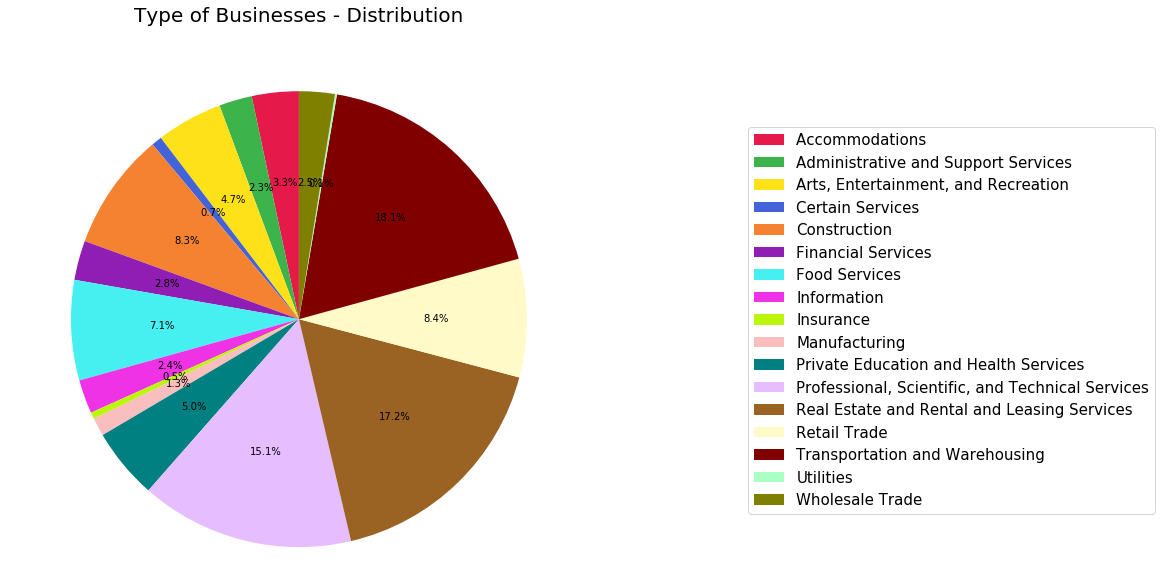

In [28]:
colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
        '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000'
        , '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
fig = plt.figure(figsize=(16,7))
ax = fig.add_axes((0,0,.5,1))
plt.pie(
    business_type_count['Number of businesses of this type'],
    #labels=business_type_count['NAICS Code Description'],
    shadow=False,
    startangle=90,
    colors=colors,
    autopct='%1.1f%%',
    radius=3000
    )
plt.title("Type of Businesses - Distribution",y=1.08,fontsize=20)
plt.legend(business_type_count['NAICS Code Description'], bbox_to_anchor=(1,0.5), loc="center right", fontsize=15, 
           bbox_transform=plt.gcf().transFigure)
#plt.subplots_adjust(left=0.0, bottom=0.1, right=0.45)
plt.axis('equal')
plt.show()

### It can be clearly inferred that the following NAICS (Codes and descriptions) would greatly benefit from the tax break since they contribute less than 2% of shops in the San Francisco area

* NAICS Code - 3100-3399 - **Manufacturing**
* NAICS Code - 5240-5249 - **Insurance**
* NAICS Code - 2200-2299 - **Utilities**

### These businesses will greatly benefit from the San Francisco county's scheme of tax breaks

## Analyzing business over the years

In [29]:
business_year=df1

In [30]:
business_year['Business Start Date']=pd.to_datetime(business_year['Business Start Date'])

In [31]:
business_year['Business End Date']=pd.to_datetime(business_year['Business End Date'])

In [32]:
business_year.columns

Index(['Location Id', 'Business Account Number', 'Ownership Name', 'DBA Name',
       'Street Address', 'City', 'State', 'Source Zipcode',
       'Business Start Date', 'Business End Date', 'Location Start Date',
       'Location End Date', 'Mail Address', 'Mail City', 'Mail Zipcode',
       'Mail State', 'NAICS Code', 'NAICS Code Description', 'Parking Tax',
       'Transient Occupancy Tax', 'LIC Code', 'LIC Code Description',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries',
       'Business Corridor', 'Business Location', 'Address', 'Lat/Long'],
      dtype='object')

In [33]:
business_year['Business Start Year']=business_year['Business Start Date'].dt.year

### This dataset contains businesses that might open in the future as well (Business having start dates greater than current year - 2018). Let us filter all records upto to the year 2018 for this analysis


In [34]:
business_year_current=business_year[business_year['Business Start Year']<=2018]

In [35]:
business_year_current['Source Zipcode']=business_year_current['Source Zipcode'].astype(str)

/Users/hramakrishnan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
business_year_current=business_year_current[(business_year_current['Source Zipcode'].str.startswith('94'))&(business_year_current['State']=='CA')]

In [37]:
business_year_current_type=business_year_current[business_year_current['NAICS Code Description'].notnull()]

In [38]:
businesses_per_year=business_year_current_type.groupby(['Business Start Year'])['Location Id'].count().reset_index()

#### Since the dataset contains data of businesses from the 1800's, I an interested in knowing the years in the dataset when less than 100 businesses started. I will be using this data to filter the data further to remove insignificant business data

In [39]:
year_business_100=businesses_per_year[businesses_per_year['Location Id']<100]

In [40]:
year_business_100_list=year_business_100['Business Start Year'].tolist()

In [41]:
year_business_100_list

[1849,
 1897,
 1932,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967]

* The above list is the years when less than 100 businesses started.
* I can clearly infer that from the year 1849 to 1967 less than 100 businesses strated every year. Hence I am excluding that from my current analysis

In [42]:
business_year_current_type=business_year_current_type[business_year_current_type['Business Start Year']>1968]

In [43]:
business_year_current_type_year=business_year_current_type.groupby(['Business Start Year','NAICS Code Description']).agg({'Location Id':'count'}).reset_index()

In [44]:
business_year_current_type_year_pivot = business_year_current_type_year.pivot(index='Business Start Year', columns='NAICS Code Description', values='Location Id')

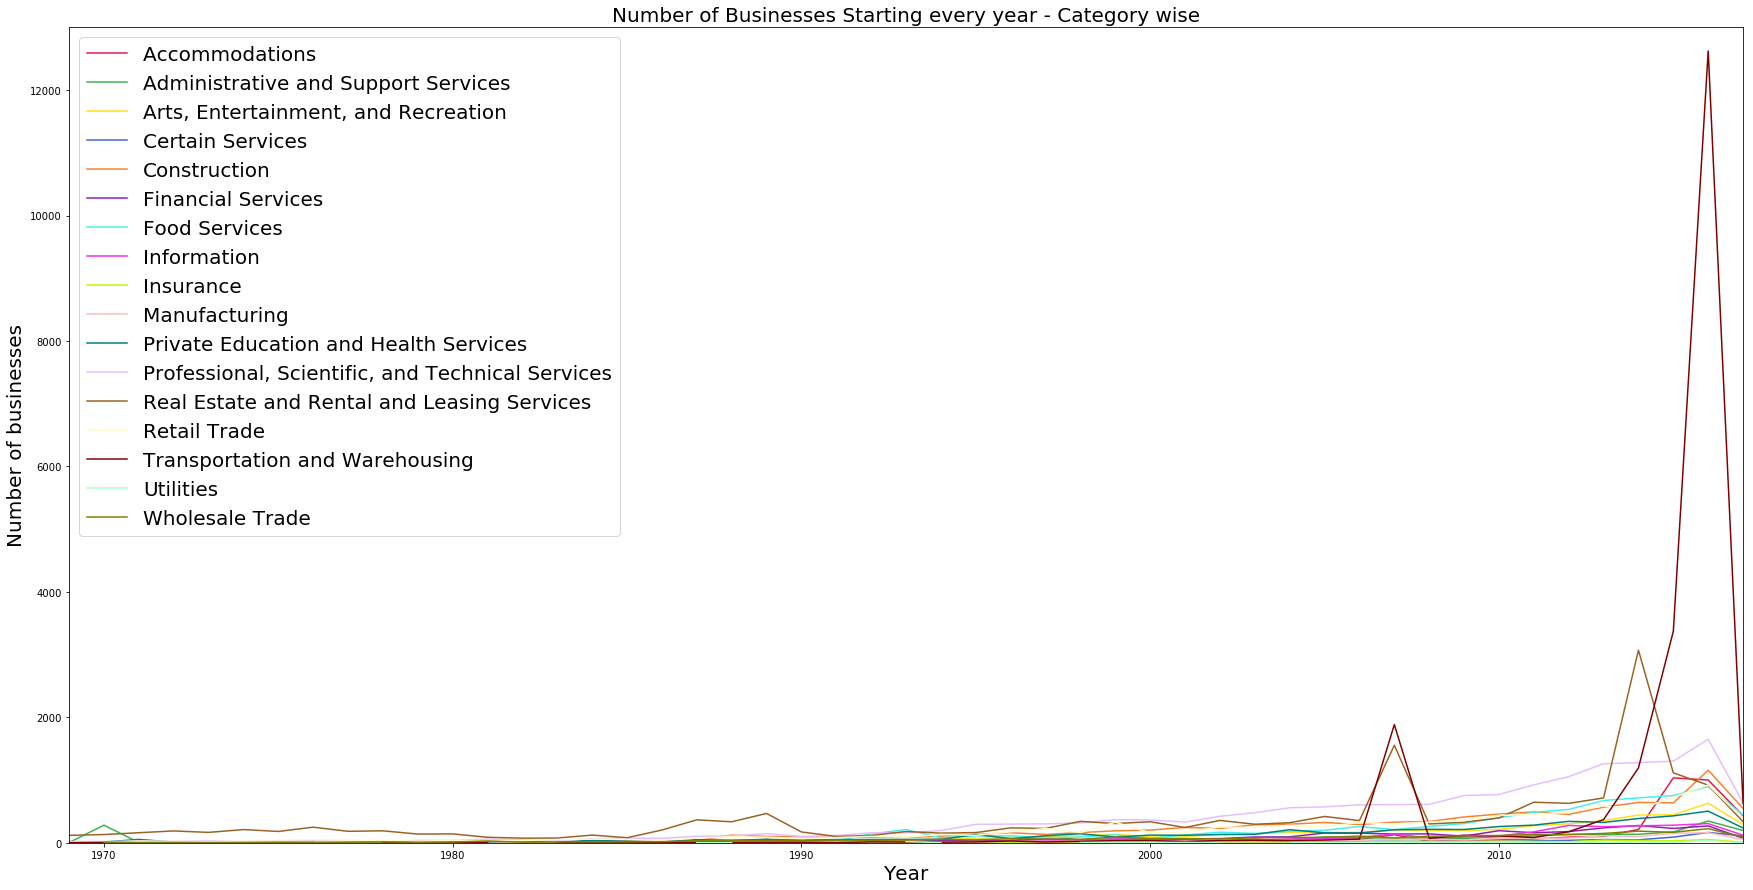

In [45]:
ax=business_year_current_type_year_pivot.plot(color=colors,figsize=(30,15))
plt.title('Number of Businesses Starting every year - Category wise',fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Number of businesses',fontsize=20)
plt.legend(prop={'size': 20})
ax.set_ylim(0,13000)
plt.show()

* The above graph gives us the idea of the categories that have many businesses coming up in certain years (spikes in the graph in certain years).
* To understand the general trend and analyze the spikes further, I filter the data after the year 2000 and set the y value limit to 5000 ( Since there is only one year where the category Transporation and Warehousing spikes to ~13000)


In [46]:
business_year_current_type_year_2000=business_year_current_type_year[business_year_current_type_year['Business Start Year']>2000]

In [47]:
business_year_current_type_year_2000_pivot = business_year_current_type_year_2000.pivot(index='Business Start Year', columns='NAICS Code Description', values='Location Id')

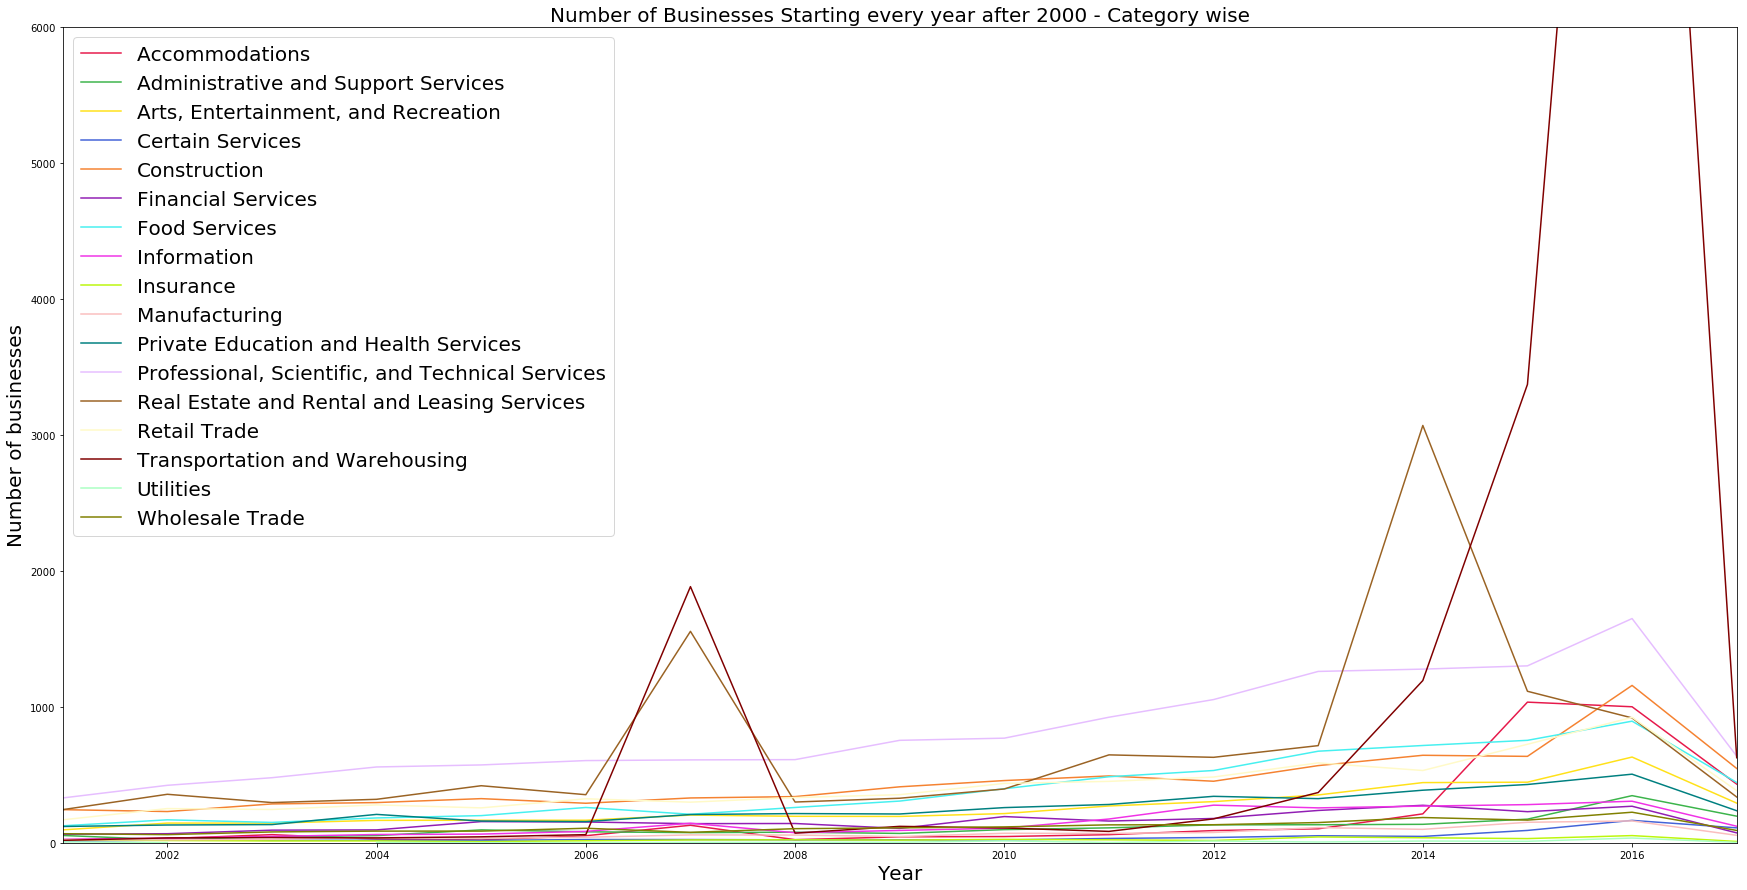

In [48]:
ax=business_year_current_type_year_2000_pivot.plot(color=colors,figsize=(30,15))
plt.title('Number of Businesses Starting every year after 2000 - Category wise',fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Number of businesses',fontsize=20)
plt.legend(prop={'size': 20})
ax.set_ylim(0,6000)
plt.show()

## Inference 
* In the year 2007 and 2014 we notice significant increase in businesses starting in **Real Estate, Rental and Leasing Services**
* Similarly in the year 2016, a significant number of businesses (12624) have started in the **Transportation and Warehousing** category.
* We also notice overall gradual increase in businesses being setup in the **Professional, Scientific and Technical Services** category over time .
* Number of businesses opening in the **Food Services** categories has been increasing from 2007 
* We can also clearly notice that number of businesses starting in 2017 decreases significantly from 2016 to 2017. One reason for this might be due to the fact that 2017 year contains only data from January - June. There might be a possibility that the dataset being analyzed might be created mid year in 2017.

### The spikes in the real estate businesses can be attributed to the increase in inflow of people into the Bay Area and increase in demand for houses. The spikes and gradual increase in the Transportation & Warehousing category would be due to a lot of businesses in the area and the need for transportation services so that people have convenient options to commute



## Scope of analysis in the future

* One interesting real time dashboard to build using this data would be a dashboard to see how the businesses of different categories have evolved in different locations by altering the year parameter (different pockets) in the city
* Analysis of start date of businesses was done in this analysis. But this dataset also contains Business and Location end dates. Using this data, it will be interesting to know what types of businesses survive the longest and the businesses that have a shorter life span
* This dataset contains the LIC Code of each of the business location. Spending further time to categorize each business and the LIC categories applicable to it, we can get an idea of business under different LIC categories.
* As mentioned in one of the analysis, certain businesses come under different NAICS categories. Businesses that provide different kinds of services can be identified 

### Data exploration - example (to identify spellings related to San Francisco)

<img src="screenshots/cities.png">

### Analysis tools:
* Python 
* Excel